# GRU

In [ ]:
# Import necessary packages
import time
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
!pip install pytorch_lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
# Mount Device
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
%cd '/content/gdrive/MyDrive/ECSE_552/Project'

## Data Preparation

In [ ]:
# Import the dataset
df = pd.read_csv('data/ON_demand_weather_17-20.csv', index_col=0)


# Do all the preprocessing required
from preprocessing.preprocessing import one_hot_encode_days, one_hot_encode_months, time_differencing, split_and_scale, sin_cos_waves, sliding_windows


# Remove weather stations and market demand columns
df.drop(['Market Demand',
         'toronto_Temp (C)',
         'hamilton_Temp (C)',
         'ottawa_Temp (C)',
         'kitchener_Temp (C)',
         'london_Temp (C)',
         'windsor_Temp (C)'], axis=1, inplace=True)
df = sin_cos_waves(df, lst_of_freq=['HalfDay', 'Day', 'Week', 'TwoYears'], drop_datetime_columns=True)

# Apply scaling if desired and split dataset into train, validation, and testset

scaler = 'standard'  # Define the type of scaler, options are 'min-max', 'standard', and None
columns_to_scale = list(df.columns) # Define columns to be scaled, add time-differenced column if applicable
columns_to_scale.remove('Date')
columns_to_scale.remove('Holiday')
target_column = 'Ontario Demand'  # Define target column (required to allow unscaling later), change to time-differenced column if applicable
vali_set_start_date='2019-07-01'  # First day of validation set
test_set_start_date='2020-01-01'  # First day of test set

train_df, vali_df, test_df, target_scaler = split_and_scale(df,
                                                            scaler=scaler,
                                                            columns_to_scale=columns_to_scale,
                                                            target_column=target_column,
                                                            vali_set_start_date=vali_set_start_date,
                                                            test_set_start_date=test_set_start_date)

## Model Training and Evaluation (Intelligent Grid Search)

#### 1Hour Predictions

In [ ]:
# Grid Search Parameters
window_sizes = [18, 24, 36, 48]
perform_feature_shifts = [1, False]
n_neurons = [64, 96, 128]
n_layers = [1]
result_dic = {"window_size":[], "perform_feature_shift":[], "n_neurons": [], "n_layers":[], "loss_scaled":[], "loss_unscaled":[]}

In [ ]:
for window_size in window_sizes:
  for perform_feature_shift in perform_feature_shifts:
    window_size = window_size
    flatten = False
    output_window_size = 1
    perform_feature_shift = perform_feature_shift

    # note that the function removes the 'Date' column (not numeric)
    x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
    x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
    x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
    # repeat function call for validation and test data

    # Batch and shuffle datasets
    SHUFFLE_BUFFER_SIZE = 100
    BATCH_SIZE = 32
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
    
    for n_neuron in n_neurons:
      for n_layer in n_layers:
        GRU_model = tf.keras.models.Sequential([tf.keras.layers.GRU(n_neuron, return_sequences=False),
                                                tf.keras.layers.Dense(units=1)])

        # Callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
        # checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/ECSE_552/Project/Checkpoints', save_weights_only=True)

        GRU_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
        history = GRU_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

        loss_fun = RMSELoss()
        y_pred = GRU_model.predict(x_vali)
        y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
        y_vali_tensor = torch.from_numpy(y_vali)
        y_pred_tensor = torch.from_numpy(y_pred)
        unscaled_y_pred = torch.from_numpy(target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
        unscaled_target = torch.from_numpy(target_scaler.inverse_transform(y_vali.reshape(-1, 1)))
        loss_fun = RMSELoss()
        loss_unscaled = loss_fun(unscaled_y_pred, unscaled_target)
        loss_scaled = loss_fun(y_pred_tensor, y_vali_tensor)
        # print("Unscaled loss: {}".format(loss_unscaled))
        # print("Scaled loss: {}".format(loss_scaled))

        # Append to dictionary
        result_dic['window_size'].append(window_size)
        result_dic['perform_feature_shift'].append(perform_feature_shift)
        result_dic['n_neurons'].append(n_neuron)
        result_dic['n_layers'].append(n_layer)
        result_dic['loss_scaled'].append(loss_scaled)
        result_dic['loss_unscaled'].append(loss_unscaled)

------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
Epoch 1/500
683/683 [==============================] - 36s 5ms/step - loss: 0.1294 - val_loss: 0.0457
Epoch 2/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0205 - val_loss: 0.0285
Epoch 3/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0135 - val_loss: 0.0217
Epoch 4/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0099 - val_loss: 0.0168
Epoch 5/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0080 - val_loss: 0.0137
Epoch 6/500
683/683 [==============================] - 3s 4ms/step - loss: 0.007

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df['loss_scaled'] = result_df['loss_scaled'].apply(lambda x: x.item())
result_df['loss_unscaled'] = result_df['loss_unscaled'].apply(lambda x: x.item())
result_df

,window_size,perform_feature_shift,n_neurons,n_layers,loss_scaled,loss_unscaled
0,12,False,32,1,0.075788,169.988129
1,12,False,64,1,0.069248,155.318354
2,12,False,96,1,0.071330,159.988874
3,12,False,128,1,0.072487,162.583402
4,12,1,32,1,0.070686,158.544353
5,12,1,64,1,0.067454,151.295371
6,12,1,96,1,0.067367,151.099861
7,12,1,128,1,0.067553,151.518530
8,18,False,32,1,0.071709,160.839695
9,18,False,64,1,0.071643,160.691782


In [ ]:
result_df.to_csv('TrainingResults/GRU_STDScaleNoHoliday_NewShift_TF.csv')

#### 24Hour Sequence Predictions

In [ ]:
# Grid Search Parameters
window_sizes = [24, 48]
perform_feature_shifts = [24, False]
n_neurons = [64, 96, 128]
n_layers = [1]
output_window_size=24
flatten=False
result_dic = {"window_size":[], "perform_feature_shift":[], "n_neurons": [], "n_layers":[], "loss_scaled":[], "loss_unscaled":[]}

In [ ]:
for window_size in window_sizes:
  for perform_feature_shift in perform_feature_shifts:

    # note that the function removes the 'Date' column (not numeric)
    x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
    x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
    x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
    # repeat function call for validation and test data

    SHUFFLE_BUFFER_SIZE = 100
    BATCH_SIZE = 32
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
    for n_neuron in n_neurons:
      for n_layer in n_layers:
        GRUSeq_model = tf.keras.models.Sequential([tf.keras.layers.GRU(n_neuron, return_sequences=False),
                                                tf.keras.layers.Dense(units=24),
                                                tf.keras.layers.Reshape([24, 1])])

        # Callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

        GRUSeq_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
        history = GRUSeq_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

        loss_fun = RMSELoss()
        y_pred = GRUSeq_model.predict(x_vali)
        y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
        y_vali_tensor = torch.from_numpy(y_vali)
        y_pred_tensor = torch.from_numpy(y_pred)
        unscaled_y_pred = torch.from_numpy(target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
        unscaled_target = torch.from_numpy(target_scaler.inverse_transform(y_vali.reshape(-1, 1)))
        loss_fun = RMSELoss()
        loss_unscaled = loss_fun(unscaled_y_pred, unscaled_target)
        loss_scaled = loss_fun(y_pred_tensor, y_vali_tensor)

        # Append to dictionary
        result_dic['window_size'].append(window_size)
        result_dic['perform_feature_shift'].append(perform_feature_shift)
        result_dic['n_neurons'].append(n_neuron)
        result_dic['n_layers'].append(n_layer)
        result_dic['loss_scaled'].append(loss_scaled)
        result_dic['loss_unscaled'].append(loss_unscaled)

------------------------------
Sliding windows created using a window size of 48 and forecast length of 24.
------------------------------
------------------------------
Sliding windows created using a window size of 48 and forecast length of 24.
------------------------------
------------------------------
Sliding windows created using a window size of 48 and forecast length of 24.
------------------------------
Epoch 1/500
682/682 [==============================] - 6s 6ms/step - loss: 0.2300 - val_loss: 0.1998
Epoch 2/500
682/682 [==============================] - 4s 5ms/step - loss: 0.1271 - val_loss: 0.1729
Epoch 3/500
682/682 [==============================] - 4s 6ms/step - loss: 0.1104 - val_loss: 0.1578
Epoch 4/500
682/682 [==============================] - 4s 6ms/step - loss: 0.1044 - val_loss: 0.1520
Epoch 5/500
682/682 [==============================] - 4s 6ms/step - loss: 0.0985 - val_loss: 0.1506
Epoch 6/500
682/682 [==============================] - 4s 5ms/step - loss: 0.0

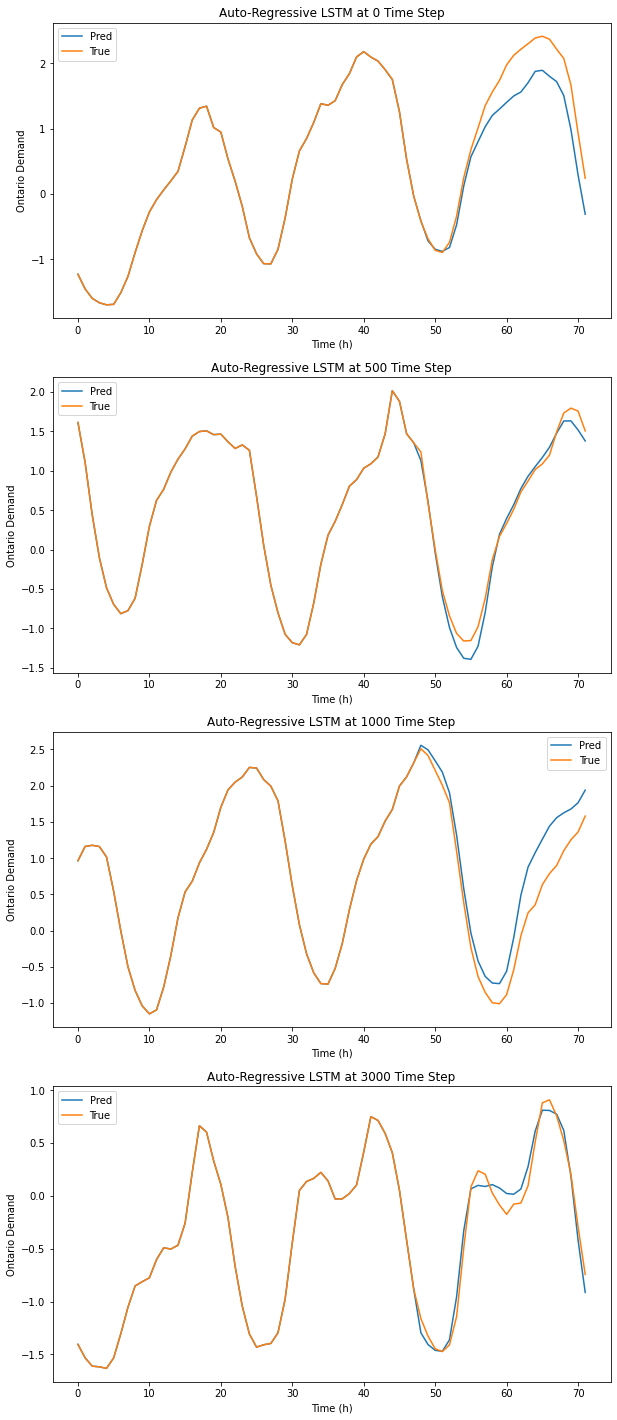

In [ ]:
predictions = []
for i in [0, 500, 1000, 3000]:
  pred = LSTM_model.predict(x_vali[i].reshape(1, x_vali[i].shape[0], x_vali[i].shape[1]))
  pred = pred.reshape(pred.shape[1])
  predictions.append(pred)
# Pressure test results
j = 0
fig, ax = plt.subplots(4, 1,  figsize=(10, 25))
for i in [0, 500, 1000, 3000]:
  ax[j].plot(np.concatenate([x_vali[i][:window_size, -1], predictions[j]]), label='Pred')
  ax[j].plot(np.concatenate([x_vali[i][:window_size, -1], y_vali[i]]), label='True')
  ax[j].legend()
  ax[j].set_xlabel('Time (h)')
  ax[j].set_ylabel('Ontario Demand')
  ax[j].set_title('Auto-Regressive LSTM at {} Time Step'.format(i))
  j += 1
plt.show()

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df['loss_scaled'] = result_df['loss_scaled'].apply(lambda x: x.item())
result_df['loss_unscaled'] = result_df['loss_unscaled'].apply(lambda x: x.item())
result_df.to_csv('TrainingResults/GRU_Seqence_TF.csv')

#### 24Hour AutoRegressive Predictions

In [ ]:
# Grid Search Parameters
window_sizes = [24, 48]
perform_feature_shifts = [1, False]
n_neurons = [64, 96, 128]
n_layers = [1]
output_window_size=24
flatten = False
result_dic = {"window_size":[], "perform_feature_shift":[], "n_neurons": [], "n_layers":[], "loss_scaled":[], "loss_unscaled":[]}

In [ ]:
for window_size in window_sizes:
  for perform_feature_shift in perform_feature_shifts:
    

    # Sliding windows
    # note that the function removes the 'Date' column (not numeric)
    x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
    x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
    x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
    # repeat function call for validation and test data

    SHUFFLE_BUFFER_SIZE = 100
    BATCH_SIZE = 32
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
    for n_neuron in n_neurons:
      for n_layer in n_layers:
        class ARGRU(tf.keras.Model):
          def __init__(self, units, out_steps):
            super().__init__()
            self.out_steps = out_steps
            self.units = units
            self.GRU_cell = tf.keras.layers.GRUCell(units)
            # Also wrap the GRUCell in an RNN to simplify the `warmup` method.
            self.GRU_rnn = tf.keras.layers.RNN(self.GRU_cell, return_state=True)
            self.dense = tf.keras.layers.Dense(1)
          
          def warmup(self, inputs):
            # inputs.shape => (batch, time, features)
            # x.shape => (batch, GRU_units)
            x, *state = self.GRU_rnn(inputs)

            # predictions.shape => (batch, features)
            prediction = self.dense(x)
            return prediction, state

          def call(self, inputs, training=None):
            warmup_input = inputs[:, :-self.out_steps, :]
            out_input = inputs[:, -self.out_steps:, :]
            # Use a TensorArray to capture dynamically unrolled outputs.
            predictions = []
            # Initialize the GRU state
            prediction, state = self.warmup(warmup_input)
            
            # Insert the first prediction
            predictions.append(prediction)

            # Run the rest of the prediction steps
            for n in range(self.out_steps - 1):
              # Use the last electricity prediction as part of the input
              x = tf.concat([out_input[:, n, :-1], prediction], -1)
              # Execute one GRU step.
              x, state = self.GRU_cell(x, states=state,
                                        training=training)
              # Convert the GRU output to a prediction.
              prediction = self.dense(x)
              # Add the prediction to the output
              predictions.append(prediction)

            # predictions.shape => (time, batch, features)
            predictions = tf.stack(predictions)
            # predictions.shape => (batch, time, features)
            predictions = tf.transpose(predictions, [1, 0, 2])
            return predictions

        # Callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

        ARGRU_model = ARGRU(n_neuron, output_window_size)
        ARGRU_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
        history = ARGRU_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

        loss_fun = RMSELoss()
        y_pred = ARLSTM_model.predict(x_vali)
        y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
        y_vali_tensor = torch.from_numpy(y_vali)
        y_pred_tensor = torch.from_numpy(y_pred)
        unscaled_y_pred = torch.from_numpy(target_scaler.inverse_transform(y_pred.reshape(-1, 1)))
        unscaled_target = torch.from_numpy(target_scaler.inverse_transform(y_vali.reshape(-1, 1)))
        loss_fun = RMSELoss()
        loss_unscaled = loss_fun(unscaled_y_pred, unscaled_target)
        loss_scaled = loss_fun(y_pred_tensor, y_vali_tensor)

        # Append to dictionary
        result_dic['window_size'].append(window_size)
        result_dic['perform_feature_shift'].append(perform_feature_shift)
        result_dic['n_neurons'].append(n_neuron)
        result_dic['n_layers'].append(n_layer)
        result_dic['loss_scaled'].append(loss_scaled)
        result_dic['loss_unscaled'].append(loss_unscaled)

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df['loss_scaled'] = result_df['loss_scaled'].apply(lambda x: x.item())
result_df['loss_unscaled'] = result_df['loss_unscaled'].apply(lambda x: x.item())
result_df.to_csv('TrainingResults/GRU_Autoregressive_TF.csv')

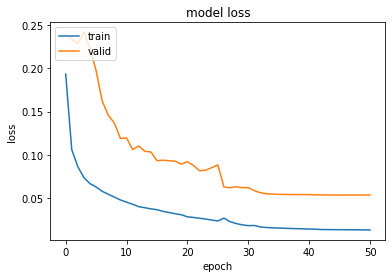

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
predictions = []
for i in [0, 500, 1000, 3000]:
  pred = ARLSTM_model.predict(x_vali[i].reshape(1, x_vali[i].shape[0], x_vali[i].shape[1]))
  pred = pred.reshape(pred.shape[1])
  predictions.append(pred)

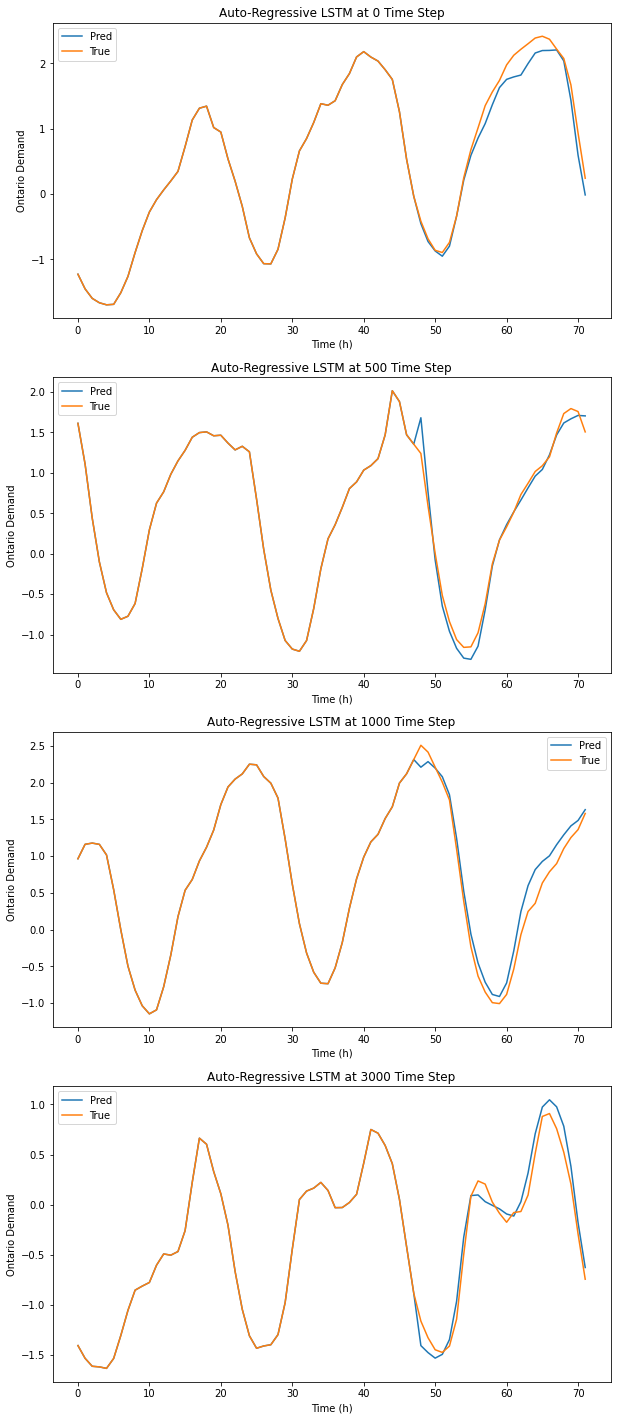

In [ ]:
# Pressure test results
j = 0
fig, ax = plt.subplots(4, 1,  figsize=(10, 25))
for i in [0, 500, 1000, 3000]:
  ax[j].plot(np.concatenate([x_vali[i][:window_size, -1], predictions[j]]), label='Pred')
  ax[j].plot(np.concatenate([x_vali[i][:window_size, -1], y_vali[i]]), label='True')
  ax[j].legend()
  ax[j].set_xlabel('Time (h)')
  ax[j].set_ylabel('Ontario Demand')
  ax[j].set_title('Auto-Regressive LSTM at {} Time Step'.format(i))
  j += 1
plt.show()

In [ ]:
window_sizes = [24]
perform_feature_shifts = [1, False]
n_neurons = [96]
n_layers = [1]
rounds = range(1, 6)
result_dic = {"Round":[], "perform_feature_shift":[], "RMSE_loss_scaled":[], "RMSE_loss_unscaled":[], "MAPE_loss_scaled":[], "MAPE_loss_unscaled":[] }
for round in rounds:
  for window_size in window_sizes:
    for perform_feature_shift in perform_feature_shifts:
      window_size = window_size
      flatten = False
      output_window_size = 1
      perform_feature_shift = perform_feature_shift

      # note that the function removes the 'Date' column (not numeric)
      x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      # repeat function call for validation and test data

      SHUFFLE_BUFFER_SIZE = 100
      BATCH_SIZE = 32
      train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
      
      for n_neuron in n_neurons:
        for n_layer in n_layers:
          LSTM_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(n_neuron, return_sequences=False),
                                                  tf.keras.layers.Dense(units=1)])

          # Callbacks
          early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
          lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
          # checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/ECSE_552/Project/Checkpoints', save_weights_only=True)

          LSTM_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
          history = LSTM_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

          y_pred = LSTM_model.predict(x_test)
          unscaled_y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
          unscaled_target = target_scaler.inverse_transform(y_test.reshape(-1, 1))
          loss_fun_RMSE = tf.keras.metrics.RootMeanSquaredError()
          loss_fun_RMSE.update_state(unscaled_y_pred, unscaled_target)
          RMSE_loss_unscaled = loss_fun_RMSE.result().numpy()
          loss_fun_RMSE.reset_states()
          loss_fun_RMSE.update_state(y_pred, y_test)
          RMSE_loss_scaled = loss_fun_RMSE.result().numpy()

          MAPE_loss_unscaled = np.mean(tf.keras.losses.MAPE(unscaled_y_pred, unscaled_target))
          MAPE_loss_scaled = np.mean(tf.keras.losses.MAPE(y_pred, y_test))

          # Append to dictionary
          result_dic['Round'].append(round)
          result_dic['perform_feature_shift'].append(perform_feature_shift)
          result_dic['RMSE_loss_scaled'].append(RMSE_loss_scaled)
          result_dic['RMSE_loss_unscaled'].append(RMSE_loss_unscaled)
          result_dic['MAPE_loss_scaled'].append(MAPE_loss_scaled)
          result_dic['MAPE_loss_unscaled'].append(MAPE_loss_unscaled)

------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
Epoch 1/500
683/683 [==============================] - 5s 5ms/step - loss: 0.1197 - val_loss: 0.0451
Epoch 2/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0199 - val_loss: 0.0283
Epoch 3/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0131 - val_loss: 0.0200
Epoch 4/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0100 - val_loss: 0.0154
Epoch 5/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0081 - val_loss: 0.0126
Epoch 6/500
683/683 [==============================] - 3s 4ms/step - loss: 0.0071

### Test Phase

Models to test:
- GRU 1h: 18 window size, 64 neurons, shift/non-shift
- GRU 24h autoregressive: 48 window size, 96 neuron, shift/non-shift
- GRU 24h sequence: 48 window size, 128 neuron, shift/non-shift

In [ ]:
window_sizes = [24]
perform_feature_shifts = [1, False]
n_neurons = [96]
n_layers = [1]
rounds = range(1, 6)
result_dic = {"Round":[], "perform_feature_shift":[], "RMSE_loss_scaled":[], "RMSE_loss_unscaled":[], "MAPE_loss_scaled":[], "MAPE_loss_unscaled":[] }
for round in rounds:
  for window_size in window_sizes:
    for perform_feature_shift in perform_feature_shifts:
      window_size = window_size
      flatten = False
      output_window_size = 1
      perform_feature_shift = perform_feature_shift

      # note that the function removes the 'Date' column (not numeric)
      x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      # repeat function call for validation and test data

      SHUFFLE_BUFFER_SIZE = 100
      BATCH_SIZE = 32
      train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
      
      for n_neuron in n_neurons:
        for n_layer in n_layers:
          GRU_model = tf.keras.models.Sequential([tf.keras.layers.GRU(n_neuron, return_sequences=False),
                                                  tf.keras.layers.Dense(units=1)])

          # Callbacks
          early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
          lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
          # checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/ECSE_552/Project/Checkpoints', save_weights_only=True)

          GRU_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
          history = GRU_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

          y_pred = GRU_model.predict(x_test)
          unscaled_y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
          unscaled_target = target_scaler.inverse_transform(y_test.reshape(-1, 1))
          loss_fun_RMSE = tf.keras.metrics.RootMeanSquaredError()
          loss_fun_RMSE.update_state(unscaled_y_pred, unscaled_target)
          RMSE_loss_unscaled = loss_fun_RMSE.result().numpy()
          loss_fun_RMSE.reset_states()
          loss_fun_RMSE.update_state(y_pred, y_test)
          RMSE_loss_scaled = loss_fun_RMSE.result().numpy()

          MAPE_loss_unscaled = np.mean(tf.keras.losses.MAPE(unscaled_y_pred, unscaled_target))
          MAPE_loss_scaled = np.mean(tf.keras.losses.MAPE(y_pred, y_test))

          # Append to dictionary
          result_dic['Round'].append(round)
          result_dic['perform_feature_shift'].append(perform_feature_shift)
          result_dic['RMSE_loss_scaled'].append(RMSE_loss_scaled)
          result_dic['RMSE_loss_unscaled'].append(RMSE_loss_unscaled)
          result_dic['MAPE_loss_scaled'].append(MAPE_loss_scaled)
          result_dic['MAPE_loss_unscaled'].append(MAPE_loss_unscaled)

------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
Epoch 1/500
683/683 [==============================] - 23s 33ms/step - loss: 0.0701 - val_loss: 0.0350
Epoch 2/500
683/683 [==============================] - 22s 32ms/step - loss: 0.0145 - val_loss: 0.0183
Epoch 3/500
683/683 [==============================] - 22s 32ms/step - loss: 0.0090 - val_loss: 0.0148
Epoch 4/500
683/683 [==============================] - 22s 32ms/step - loss: 0.0077 - val_loss: 0.0142
Epoch 5/500
683/683 [==============================] - 22s 32ms/step - loss: 0.0075 - val_loss: 0.0161
Epoch 6/500
683/683 [==============================] - 22s 32ms/step - 

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df

,Round,perform_feature_shift,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
0,1,1,0.086214,193.372208,32.817433,0.960283
1,1,False,0.084561,189.665436,35.169182,0.939574
2,2,1,0.089246,200.173660,138.211378,1.002740
3,2,False,0.085533,191.845810,29.694116,0.947936
4,3,1,0.088802,199.177338,41.523027,0.987705
5,3,False,0.086653,194.357819,32.292159,0.963163
6,4,1,0.084197,188.848389,32.633427,0.928572
7,4,False,0.090166,202.238205,76.890978,0.993792
8,5,1,0.085188,191.072586,35.303226,0.944668
9,5,False,0.083967,188.334091,35.207531,0.924024


In [ ]:
result_df.groupby(by='perform_feature_shift').mean()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,3,0.086176,193.288272,41.850793,0.953698
1,3,0.086729,194.528836,56.097698,0.964793


In [ ]:
result_df.groupby(by='perform_feature_shift').std()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,1.581139,0.002452,5.499881,19.721458,0.026507
1,1.581139,0.002218,4.975529,46.043540,0.030423


In [ ]:
result_df.to_csv("TrainingResults/GRU_1h_TestResults.csv")

In [ ]:
window_sizes = [48]
perform_feature_shifts = [1, False]
n_neurons = [96]
n_layers = [1]
rounds = range(1, 6)
result_dic = {"Round":[], "perform_feature_shift":[], "RMSE_loss_scaled":[], "RMSE_loss_unscaled":[], "MAPE_loss_scaled":[], "MAPE_loss_unscaled":[] }
output_window_size=24
flatten = False
for round in rounds:
  for window_size in window_sizes:
    for perform_feature_shift in perform_feature_shifts:
      # Sliding windows
      # note that the function removes the 'Date' column (not numeric)
      x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
      x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
      x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
      # repeat function call for validation and test data

      SHUFFLE_BUFFER_SIZE = 100
      BATCH_SIZE = 32
      train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
      for n_neuron in n_neurons:
        for n_layer in n_layers:
          class ARGRU(tf.keras.Model):
            def __init__(self, units, out_steps):
              super().__init__()
              self.out_steps = out_steps
              self.units = units
              self.GRU_cell = tf.keras.layers.GRUCell(units)
              # Also wrap the GRUCell in an RNN to simplify the `warmup` method.
              self.GRU_rnn = tf.keras.layers.RNN(self.GRU_cell, return_state=True)
              self.dense = tf.keras.layers.Dense(1)
            
            def warmup(self, inputs):
              # inputs.shape => (batch, time, features)
              x, *state = self.GRU_rnn(inputs)

              # predictions.shape => (batch, features)
              prediction = self.dense(x)
              return prediction, state

            def call(self, inputs, training=None):
              warmup_input = inputs[:, :-self.out_steps, :]
              out_input = inputs[:, -self.out_steps:, :]
              # Use a TensorArray to capture dynamically unrolled outputs.
              predictions = []
              # Initialize the GRU state
              prediction, state = self.warmup(warmup_input)
              # Insert the first prediction
              predictions.append(prediction)

              # Run the rest of the prediction steps
              for n in range(self.out_steps - 1):
                # Use the last electricity prediction as part of the input
                x = tf.concat([out_input[:, n, :-1], prediction], -1)
                # Execute one GRU step.
                x, state = self.GRU_cell(x, states=state,
                                          training=training)
                # Convert the GRU output to a prediction.
                prediction = self.dense(x)
                # Add the prediction to the output
                predictions.append(prediction)

              # predictions.shape => (time, batch, features)
              predictions = tf.stack(predictions)
              # predictions.shape => (batch, time, features)
              predictions = tf.transpose(predictions, [1, 0, 2])
              return predictions

          # Callbacks
          early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
          lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

          ARGRU_model = ARGRU(n_neuron, output_window_size)
          ARGRU_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
          history = ARGRU_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

          y_pred = ARGRU_model.predict(x_test)
          unscaled_y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
          unscaled_target = target_scaler.inverse_transform(y_test.reshape(-1, 1))
          loss_fun_RMSE = tf.keras.metrics.RootMeanSquaredError()
          loss_fun_RMSE.update_state(unscaled_y_pred, unscaled_target)
          RMSE_loss_unscaled = loss_fun_RMSE.result().numpy()
          loss_fun_RMSE.reset_states()
          loss_fun_RMSE.update_state(y_pred, y_test)
          RMSE_loss_scaled = loss_fun_RMSE.result().numpy()

          MAPE_loss_unscaled = np.mean(tf.keras.losses.MAPE(unscaled_y_pred, unscaled_target))
          MAPE_loss_scaled = np.mean(tf.keras.losses.MAPE(y_pred.reshape(-1,1), y_test.reshape(-1, 1)))

          # Append to dictionary
          result_dic['Round'].append(round)
          result_dic['perform_feature_shift'].append(perform_feature_shift)
          result_dic['RMSE_loss_scaled'].append(RMSE_loss_scaled)
          result_dic['RMSE_loss_unscaled'].append(RMSE_loss_unscaled)
          result_dic['MAPE_loss_scaled'].append(MAPE_loss_scaled)
          result_dic['MAPE_loss_unscaled'].append(MAPE_loss_unscaled)

------------------------------
Autoregressive Sliding windows created using a window size of          48 and forecast length of 24.
------------------------------
------------------------------
Autoregressive Sliding windows created using a window size of          48 and forecast length of 24.
------------------------------
------------------------------
Autoregressive Sliding windows created using a window size of          48 and forecast length of 24.
------------------------------
Epoch 1/500
682/682 [==============================] - 55s 72ms/step - loss: 0.2695 - val_loss: 0.5698
Epoch 2/500
682/682 [==============================] - 48s 71ms/step - loss: 0.2235 - val_loss: 0.3672
Epoch 3/500
682/682 [==============================] - 48s 71ms/step - loss: 0.1168 - val_loss: 0.2668
Epoch 4/500
682/682 [==============================] - 48s 71ms/step - loss: 0.0843 - val_loss: 0.2470
Epoch 5/500
682/682 [==============================] - 48s 71ms/step - loss: 0.0715 - val_loss: 0.2

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df

,Round,perform_feature_shift,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
0,1,1,0.320818,719.576477,422.975142,3.664850
1,1,False,0.335114,751.642517,408.878697,3.806581
2,2,1,0.355168,796.621643,395.338847,4.265744
3,2,False,0.310330,696.054077,213.076653,3.513882
4,3,1,0.305258,684.675720,233.055193,3.418633
5,3,False,0.326416,732.133972,258.760811,3.763157
6,4,1,0.301478,676.197754,381.323513,3.402545
7,4,False,0.326755,732.893005,221.857482,3.778412
8,5,1,0.302203,677.824158,252.276800,3.390944
9,5,False,0.311299,698.226074,2640.377357,3.617918


In [ ]:
result_df.groupby(by='perform_feature_shift').mean()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,3,0.321983,722.189929,748.590200,3.695990
1,3,0.316985,710.979150,336.993899,3.628543


In [ ]:
result_df.groupby(by='perform_feature_shift').std()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,1.581139,0.010779,24.177696,1060.473656,0.125293
1,1.581139,0.022744,51.013283,87.667359,0.373809


In [ ]:
result_df.to_csv('TrainingResults/GRU_AR_TestResult.csv')

In [ ]:
window_sizes = [48]
perform_feature_shifts = [24, False]
n_neurons = [128]
n_layers = [1]
rounds = range(1, 6)
result_dic = {"Round":[], "perform_feature_shift":[], "RMSE_loss_scaled":[], "RMSE_loss_unscaled":[], "MAPE_loss_scaled":[], "MAPE_loss_unscaled":[] }
output_window_size=24
flatten = False

for round in rounds:
  for window_size in window_sizes:
    for perform_feature_shift in perform_feature_shifts:

      # note that the function removes the 'Date' column (not numeric)
      x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      # repeat function call for validation and test data

      SHUFFLE_BUFFER_SIZE = 100
      BATCH_SIZE = 32
      train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
      for n_neuron in n_neurons:
        for n_layer in n_layers:
          GRUSeq_model = tf.keras.models.Sequential([tf.keras.layers.GRU(n_neuron, return_sequences=False),
                                                  tf.keras.layers.Dense(units=24),
                                                  tf.keras.layers.Reshape([24, 1])])

          # Callbacks
          early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
          lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

          GRUSeq_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
          history = GRUSeq_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

          y_pred = GRUSeq_model.predict(x_test)
          unscaled_y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
          unscaled_target = target_scaler.inverse_transform(y_test.reshape(-1, 1))
          loss_fun_RMSE = tf.keras.metrics.RootMeanSquaredError()
          loss_fun_RMSE.update_state(unscaled_y_pred, unscaled_target)
          RMSE_loss_unscaled = loss_fun_RMSE.result().numpy()
          loss_fun_RMSE.reset_states()
          loss_fun_RMSE.update_state(y_pred, y_test)
          RMSE_loss_scaled = loss_fun_RMSE.result().numpy()

          MAPE_loss_unscaled = np.mean(tf.keras.losses.MAPE(unscaled_y_pred, unscaled_target))
          MAPE_loss_scaled = np.mean(tf.keras.losses.MAPE(y_pred.reshape(-1, 1), y_test.reshape(-1, 1)))

          # Append to dictionary
          result_dic['Round'].append(round)
          result_dic['perform_feature_shift'].append(perform_feature_shift)
          result_dic['RMSE_loss_scaled'].append(RMSE_loss_scaled)
          result_dic['RMSE_loss_unscaled'].append(RMSE_loss_unscaled)
          result_dic['MAPE_loss_scaled'].append(MAPE_loss_scaled)
          result_dic['MAPE_loss_unscaled'].append(MAPE_loss_unscaled)

------------------------------
Sliding windows created using a window size of 48 and forecast length of 24.
------------------------------
------------------------------
Sliding windows created using a window size of 48 and forecast length of 24.
------------------------------
------------------------------
Sliding windows created using a window size of 48 and forecast length of 24.
------------------------------
Epoch 1/500
682/682 [==============================] - 47s 67ms/step - loss: 0.2342 - val_loss: 0.2067
Epoch 2/500
682/682 [==============================] - 45s 67ms/step - loss: 0.1276 - val_loss: 0.1653
Epoch 3/500
682/682 [==============================] - 45s 67ms/step - loss: 0.1051 - val_loss: 0.1568
Epoch 4/500
682/682 [==============================] - 45s 66ms/step - loss: 0.0984 - val_loss: 0.1487
Epoch 5/500
682/682 [==============================] - 45s 66ms/step - loss: 0.0954 - val_loss: 0.1404
Epoch 6/500
682/682 [==============================] - 45s 66ms/step

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df

,Round,perform_feature_shift,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
0,1,24,0.340130,762.892822,309.936031,3.661526
1,1,False,0.349649,784.243164,810.183060,3.785271
2,2,24,0.354416,794.935425,231.467399,3.845853
3,2,False,0.346206,776.521118,282.335024,3.735645
4,3,24,0.348163,780.911133,724.936208,3.770460
5,3,False,0.343985,771.540466,201.516775,3.731165
6,4,24,0.344523,772.745117,281.005368,3.715700
7,4,False,0.349855,784.705627,398.276606,3.791438
8,5,24,0.349363,783.602356,232.661278,3.718481
9,5,False,0.351287,787.918274,219.164995,3.763492


In [ ]:
result_df.groupby(by='perform_feature_shift').mean()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,3,0.348197,780.985730,382.295292,3.761402
24,3,0.347319,779.017371,356.001257,3.742404


In [ ]:
result_df.groupby(by='perform_feature_shift').std()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,1.581139,0.003005,6.738962,251.310448,0.027631
24,1.581139,0.005356,12.013899,208.914348,0.069490


In [ ]:
result_df.to_csv('TrainingResults/GRU_Seq_TestResult.csv')

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df

,Round,perform_feature_shift,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
0,1,1,0.085440,191.637360,36.090354,0.944581
1,1,False,0.084559,189.661118,35.759859,0.937609
2,2,1,0.084939,190.513245,55.353813,0.942129
3,2,False,0.084933,190.499084,41.601583,0.945199
4,3,1,0.086404,193.798309,34.779162,0.956628
5,3,False,0.103071,231.182907,37.319971,1.160898
6,4,1,0.090326,202.596832,31.972381,0.989905
7,4,False,0.084901,190.427475,26.900767,0.942465
8,5,1,0.086281,193.524109,45.445991,0.946688
9,5,False,0.088571,198.658768,43.201147,0.984629


In [ ]:
result_df.groupby(by='perform_feature_shift').mean()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,3,0.089207,200.085870,36.956665,0.994160
1,3,0.086678,194.413971,40.728340,0.955986


In [ ]:
result_df.groupby(by='perform_feature_shift').std()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,1.581139,0.007922,17.768855,6.388549,0.095079
1,1.581139,0.002127,4.771146,9.614197,0.019745


In [ ]:
result_df.to_csv("TrainingResults/LSTM_1h_TestResults.csv")

In [ ]:
window_sizes = [48]
perform_feature_shifts = [1, False]
n_neurons = [96]
n_layers = [1]
rounds = range(1, 6)
result_dic = {"Round":[], "perform_feature_shift":[], "RMSE_loss_scaled":[], "RMSE_loss_unscaled":[], "MAPE_loss_scaled":[], "MAPE_loss_unscaled":[] }
output_window_size=24
flatten = False
for round in rounds:
  for window_size in window_sizes:
    for perform_feature_shift in perform_feature_shifts:
      # Sliding windows
      # note that the function removes the 'Date' column (not numeric)
      x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
      x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
      x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=True)
      # repeat function call for validation and test data

      SHUFFLE_BUFFER_SIZE = 100
      BATCH_SIZE = 32
      train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
      for n_neuron in n_neurons:
        for n_layer in n_layers:
          class ARLSTM(tf.keras.Model):
            def __init__(self, units, out_steps):
              super().__init__()
              self.out_steps = out_steps
              self.units = units
              self.LSTM_cell = tf.keras.layers.LSTMCell(units)
              # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
              self.LSTM_rnn = tf.keras.layers.RNN(self.LSTM_cell, return_state=True)
              self.dense = tf.keras.layers.Dense(1)
            
            def warmup(self, inputs):
              # inputs.shape => (batch, time, features)
              x, *state = self.LSTM_rnn(inputs)

              # predictions.shape => (batch, features)
              prediction = self.dense(x)
              return prediction, state

            def call(self, inputs, training=None):
              warmup_input = inputs[:, :-self.out_steps, :]
              out_input = inputs[:, -self.out_steps:, :]
              # Use a TensorArray to capture dynamically unrolled outputs.
              predictions = []
              # Initialize the LSTM state
              prediction, state = self.warmup(warmup_input)
              # Insert the first prediction
              predictions.append(prediction)

              # Run the rest of the prediction steps
              for n in range(self.out_steps - 1):
                # Use the last electricity prediction as part of the input
                x = tf.concat([out_input[:, n, :-1], prediction], -1)
                # Execute one LSTM step.
                x, state = self.LSTM_cell(x, states=state,
                                          training=training)
                # Convert the LSTM output to a prediction.
                prediction = self.dense(x)
                # Add the prediction to the output
                predictions.append(prediction)

              # predictions.shape => (time, batch, features)
              predictions = tf.stack(predictions)
              # predictions.shape => (batch, time, features)
              predictions = tf.transpose(predictions, [1, 0, 2])
              return predictions

          # Callbacks
          early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
          lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

          ARLSTM_model = ARLSTM(n_neuron, output_window_size)
          ARLSTM_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
          history = ARLSTM_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

          y_pred = ARLSTM_model.predict(x_test)
          unscaled_y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
          unscaled_target = target_scaler.inverse_transform(y_test.reshape(-1, 1))
          loss_fun_RMSE = tf.keras.metrics.RootMeanSquaredError()
          loss_fun_RMSE.update_state(unscaled_y_pred, unscaled_target)
          RMSE_loss_unscaled = loss_fun_RMSE.result().numpy()
          loss_fun_RMSE.reset_states()
          loss_fun_RMSE.update_state(y_pred, y_test)
          RMSE_loss_scaled = loss_fun_RMSE.result().numpy()

          MAPE_loss_unscaled = np.mean(tf.keras.losses.MAPE(unscaled_y_pred, unscaled_target))
          MAPE_loss_scaled = np.mean(tf.keras.losses.MAPE(y_pred.reshape(-1,1), y_test.reshape(-1, 1)))

          # Append to dictionary
          result_dic['Round'].append(round)
          result_dic['perform_feature_shift'].append(perform_feature_shift)
          result_dic['RMSE_loss_scaled'].append(RMSE_loss_scaled)
          result_dic['RMSE_loss_unscaled'].append(RMSE_loss_unscaled)
          result_dic['MAPE_loss_scaled'].append(MAPE_loss_scaled)
          result_dic['MAPE_loss_unscaled'].append(MAPE_loss_unscaled)

------------------------------
Autoregressive Sliding windows created using a window size of          48 and forecast length of 24.
------------------------------
------------------------------
Autoregressive Sliding windows created using a window size of          48 and forecast length of 24.
------------------------------
------------------------------
Autoregressive Sliding windows created using a window size of          48 and forecast length of 24.
------------------------------
Epoch 1/500
682/682 [==============================] - 65s 88ms/step - loss: 0.2476 - val_loss: 0.2841
Epoch 2/500
682/682 [==============================] - 59s 86ms/step - loss: 0.1124 - val_loss: 0.2453
Epoch 3/500
682/682 [==============================] - 59s 86ms/step - loss: 0.0893 - val_loss: 0.2473
Epoch 4/500
682/682 [==============================] - 59s 87ms/step - loss: 0.0806 - val_loss: 0.2698
Epoch 5/500
682/682 [==============================] - 59s 87ms/step - loss: 0.0749 - val_loss: 0.2

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df

,Round,perform_feature_shift,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
0,1,1,0.310773,697.047546,241.251879,3.464969
1,1,False,0.343352,770.120178,335.777011,4.024692
2,2,1,0.316040,708.859924,307.191457,3.569088
3,2,False,0.331279,743.039368,342.090488,3.800389
4,3,1,0.321324,720.711792,277.128067,3.585742
5,3,False,0.304710,683.448486,324.611460,3.491510
6,4,1,0.314094,704.495972,320.606518,3.536506
7,4,False,0.325120,729.226013,333.762638,3.636638
8,5,1,0.363561,815.446899,286.983754,4.254546
9,5,False,0.338679,759.637451,382.688148,4.021060


In [ ]:
result_df.groupby(by='perform_feature_shift').mean()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,3,0.328628,737.094299,343.785949,3.794858
1,3,0.325158,729.312427,286.632335,3.682170


In [ ]:
result_df.groupby(by='perform_feature_shift').std()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,1.581139,0.015077,33.815785,22.630326,0.235093
1,1.581139,0.021806,48.908849,30.523609,0.323301


In [ ]:
result_df.to_csv('TrainingResults/LSTM_AR_TestResult.csv')

In [ ]:
window_sizes = [24]
perform_feature_shifts = [24, False]
n_neurons = [128]
n_layers = [1]
rounds = range(1, 6)
result_dic = {"Round":[], "perform_feature_shift":[], "RMSE_loss_scaled":[], "RMSE_loss_unscaled":[], "MAPE_loss_scaled":[], "MAPE_loss_unscaled":[] }
output_window_size=24
flatten = False

for round in rounds:
  for window_size in window_sizes:
    for perform_feature_shift in perform_feature_shifts:

      # note that the function removes the 'Date' column (not numeric)
      x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      x_vali, y_vali = sliding_windows(df=vali_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      x_test, y_test = sliding_windows(df=test_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size, autoregressive=False)
      # repeat function call for validation and test data

      SHUFFLE_BUFFER_SIZE = 100
      BATCH_SIZE = 32
      train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      vali_dataset = tf.data.Dataset.from_tensor_slices((x_vali, y_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
      for n_neuron in n_neurons:
        for n_layer in n_layers:
          LSTMSeq_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(n_neuron, return_sequences=False),
                                                  tf.keras.layers.Dense(units=24),
                                                  tf.keras.layers.Reshape([24, 1])])

          # Callbacks
          early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
          lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

          LSTMSeq_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
          history = LSTMSeq_model.fit(train_dataset, epochs=500, validation_data=vali_dataset, callbacks=[early_stopping, lr_scheduler])

          y_pred = LSTMSeq_model.predict(x_test)
          unscaled_y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
          unscaled_target = target_scaler.inverse_transform(y_test.reshape(-1, 1))
          loss_fun_RMSE = tf.keras.metrics.RootMeanSquaredError()
          loss_fun_RMSE.update_state(unscaled_y_pred, unscaled_target)
          RMSE_loss_unscaled = loss_fun_RMSE.result().numpy()
          loss_fun_RMSE.reset_states()
          loss_fun_RMSE.update_state(y_pred, y_test)
          RMSE_loss_scaled = loss_fun_RMSE.result().numpy()

          MAPE_loss_unscaled = np.mean(tf.keras.losses.MAPE(unscaled_y_pred, unscaled_target))
          MAPE_loss_scaled = np.mean(tf.keras.losses.MAPE(y_pred.reshape(-1, 1), y_test.reshape(-1, 1)))

          # Append to dictionary
          result_dic['Round'].append(round)
          result_dic['perform_feature_shift'].append(perform_feature_shift)
          result_dic['RMSE_loss_scaled'].append(RMSE_loss_scaled)
          result_dic['RMSE_loss_unscaled'].append(RMSE_loss_unscaled)
          result_dic['MAPE_loss_scaled'].append(MAPE_loss_scaled)
          result_dic['MAPE_loss_unscaled'].append(MAPE_loss_unscaled)

------------------------------
Sliding windows created using a window size of 24 and forecast length of 24.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 24.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 24.
------------------------------
Epoch 1/500
682/682 [==============================] - 33s 5ms/step - loss: 0.2584 - val_loss: 0.2115
Epoch 2/500
682/682 [==============================] - 3s 4ms/step - loss: 0.1205 - val_loss: 0.1676
Epoch 3/500
682/682 [==============================] - 3s 4ms/step - loss: 0.1103 - val_loss: 0.1549
Epoch 4/500
682/682 [==============================] - 3s 4ms/step - loss: 0.1046 - val_loss: 0.1511
Epoch 5/500
682/682 [==============================] - 3s 4ms/step - loss: 0.0975 - val_loss: 0.1518
Epoch 6/500
682/682 [==============================] - 3s 4ms/step - loss: 0.

In [ ]:
result_df = pd.DataFrame(result_dic)
result_df

,Round,perform_feature_shift,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
0,1,24,0.356014,798.518921,263.338461,3.729566
1,1,False,0.360434,808.433350,284.876774,3.771348
2,2,24,0.358672,804.482056,244.342235,3.753532
3,2,False,0.357125,801.010925,341.913928,3.817960
4,3,24,0.347871,780.254578,345.816626,3.747763
5,3,False,0.345638,775.247559,260.512299,3.731303
6,4,24,0.360055,807.584534,273.097389,3.744222
7,4,False,0.353504,792.889893,253.833934,3.735006
8,5,24,0.349514,783.940857,865.072859,3.715874
9,5,False,0.349280,783.415466,307.024599,3.796276


In [ ]:
result_df.groupby(by='perform_feature_shift').mean()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,3,0.353196,792.199438,289.632307,3.770378
24,3,0.354425,794.956189,398.333514,3.738191


In [ ]:
result_df.groupby(by='perform_feature_shift').std()

,Round,RMSE_loss_scaled,RMSE_loss_unscaled,MAPE_loss_scaled,MAPE_loss_unscaled
perform_feature_shift,,,,,
False,1.581139,0.005924,13.287055,36.013793,0.037795
24,1.581139,0.005462,12.251380,263.735049,0.015295


In [ ]:
result_df.to_csv('TrainingResults/LSTM_Seq_TestResult.csv')

## Model Training and Evaluation (Random Search)

### Data Preparation

In [ ]:
import time
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
from torchvision import transforms
!pip install pytorch_lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold 
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import math
!pip install scikit-learn --upgrade
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
# import warnings
# warnings.filterwarnings('ignore')
%cd '/content/gdrive/MyDrive/ECSE_552/Project'

In [ ]:
# RMSELoss
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-10):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
# Create checkpoint callback that monitors validation loss
class LitAutoEncoder(pl.LightningModule):
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.backbone(x)

        # 1. calculate loss
        loss = F.cross_entropy(y_hat, y)

        # 2. log `val_loss`
        self.log('val_loss', loss)

# Logger
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning.loggers import LightningLoggerBase
from pytorch_lightning.loggers.base import rank_zero_experiment
from collections import defaultdict 


class DictLogger(LightningLoggerBase):

    def __init__(self):
        super().__init__()
        def def_value(): 
            return []
              
        # Defining the dict 
        self.metrics = defaultdict(def_value) 


    @property
    def name(self):
        return 'DictLogger'

    @property
    @rank_zero_experiment
    def experiment(self):
        # Return the experiment object associated with this logger.
        pass

    @property
    def version(self):
        # Return the experiment version, int or str.
        return '0.1'

    @rank_zero_only
    def log_hyperparams(self, params):
        # params is an argparse.Namespace
        # your code to record hyperparameters goes here
        pass

    @rank_zero_only
    def log_metrics(self, metrics, step):
        # metrics is a dictionary of metric names and values
        # your code to record metrics goes here
        for key in metrics.keys():
            self.metrics[key].append(metrics[key])

    @rank_zero_only
    def save(self):
        # Optional. Any code necessary to save logger data goes here
        # If you implement this, remember to call `super().save()`
        # at the start of the method (important for aggregation of metrics)
        super().save()

    @rank_zero_only
    def finalize(self, status):
        # Optional. Any code that needs to be run after training
        # finishes goes here
        pass

In [ ]:
# Import the dataset
df = pd.read_csv('data/ON_demand_weather_17-20.csv', index_col=0)


# Do all the preprocessing required
from preprocessing.preprocessing import one_hot_encode_days, one_hot_encode_months, time_differencing, split_and_scale, sin_cos_waves, sliding_windows, split_and_scale_no_val


# Remove weather stations and market demand columns
df.drop(['Market Demand',
         'toronto_Temp (C)',
         'hamilton_Temp (C)',
         'ottawa_Temp (C)',
         'kitchener_Temp (C)',
         'london_Temp (C)',
         'windsor_Temp (C)'], axis=1, inplace=True)


# One-hot encode days of week, drop_column=True removes original ordinary column
# df = one_hot_encode_days(df, drop_column=True)


# One-hot encode months, drop_column=True removes original ordinary column
# df = one_hot_encode_months(df, drop_column=True)


# Create sin-cos-waves for datetime information
# possible sin_cos-columns for lst_of_freq=['HalfDay', 'Day', 'Week', 'TwoYears']
# if drop_datetime_columns=True, these columns will be dropped: Hour, Day of Month, Day of Week, Month
df = sin_cos_waves(df, lst_of_freq=['Day', 'Week'], drop_datetime_columns=True)


# Apply time-differencing
# 'lag' defines the time-differencing interval/step-size
# remove_first_rows=True removes those rows at the beginning of the differenced series that are NaNs
# df = time_differencing(df, column='Ontario Demand', lag=1, remove_first_rows=True)


# Apply scaling if desired and split dataset into train, validation, and testset
scaler = 'min-max'  # Define the type of scaler, options are 'min-max', 'standard', and None
columns_to_scale = ['Ontario Demand', 'Weighted Average Temp (C)', 'Day sin', 'Day cos', 'Week sin', 'Week cos']  # Define columns to be scaled, add time-differenced column if applicable
target_column = columns_to_scale[0]  # Define target column (required to allow unscaling later), change to time-differenced column if applicable
vali_set_start_date='2019-07-01'  # First day of validation set
test_set_start_date='2020-01-01'  # First day of test set


train_df, vali_df, test_df, target_scaler = split_and_scale(df,
                                                            scaler=scaler,
                                                            columns_to_scale=columns_to_scale,
                                                            target_column=target_column,
                                                            vali_set_start_date=vali_set_start_date,
                                                            test_set_start_date=test_set_start_date)
'''
train_df,  test_df, target_scaler = split_and_scale_no_val(df,
                                                          scaler=scaler,
                                                          columns_to_scale=columns_to_scale,
                                                          target_column=target_column,
                                                          test_set_start_date=test_set_start_date)
#'''


train_df.drop(['Holiday'], axis = 1, inplace=True)
vali_df.drop(['Holiday'], axis = 1, inplace=True)
test_df.drop(['Holiday'], axis = 1, inplace=True) #Holiday feature skews results, observable even within the first 500h and 1000h of results




------------------------------
Encoded following frequencies via sin-cos waves:  ['Day', 'Week']
Dropped following columns: [Hour, Day of Month, Day of Week, Month]
------------------------------
------------------------------
Dataset scaled (if applicable) and split into:
Training data: 21864 rows
Validation data: 4416 rows
Test data: 8784 rows
------------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Search Setup

After trying out a few pre-processing steps it was determined that:

1. Standardization increased training time significantly when compared to min-max normalization with no apparent difference in MSE. That being said, the hyper-parameter search would be done on min-max and then we would test out standardization again.

2. Holiday feature caused increase in MSE 


In [ ]:
# Sample design space by picking n random samples

# column 1 = batch size
# column 2 = hidden layer size
# column 3 = number of hidden layer
# column 4 = dropout probability
# column 5 = starting learning rate

num_design_points = 60

search_results = np.zeros((num_design_points,3))
batch_size_choices = np.array(random.choices([8, 16, 24, 32, 40], k=num_design_points))
hidden_layer_size_choices = np.array(random.choices([16, 32, 64, 128, 256], k=num_design_points))
num_hidden_layers_choices = np.array(random.choices([1, 2, 3], k=num_design_points))
dropout_choices = np.array(random.choices([0, 0.05, 0.1, 0.15, 0.2, 0.25], k=num_design_points))
start_lr_choices = np.array(random.choices([1e-3, 5e-4, 1e-4], k=num_design_points)) # starting lr is too larger and we get bad models
window_size_choices = np.array(random.choices([8, 16, 24, 32, 40], k=num_design_points))
designs = np.array([batch_size_choices, hidden_layer_size_choices, num_hidden_layers_choices, dropout_choices, start_lr_choices, window_size_choices]).T

# Does K-Fold cross validation on Tensor dataset
# Return average loss and average training time
def doKFold(x, y, model, batch_size, nfolds):
  kfold = KFold(n_splits=nfolds)
  
  avg_time = 0
  avg_train_loss = 0
  avg_val_loss = 0


  for train_indices, val_indices in kfold.split(x):

    # Reset all model parameters for each fold
    for layer in model.children():
      if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

    # Build training and validation dataloaders from tensors
    fold_train_x = x[train_indices]
    fold_train_y = y[train_indices]

    fold_val_x = x[val_indices]
    fold_val_y = y[val_indices]

    fold_train_data = TensorDataset(fold_train_x, fold_train_y)
    fold_train_data = TensorDataset(fold_val_x, fold_val_y)

    fold_train_dataloader = DataLoader(fold_train_data, batch_size=batch_size, shuffle=True)
    fold_val_dataloader = DataLoader(fold_train_data, batch_size=batch_size, shuffle=False)
    
    # Train model
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    logger = DictLogger()
    early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=0.0001, patience=5)
    trainer = pl.Trainer(max_epochs=100, gpus=1, progress_bar_refresh_rate=30, logger=logger, callbacks=[early_stopping])
    start_time = time.time()
    
    trainer.fit(model, fold_train_dataloader, fold_val_dataloader)
  
    fold_training_time = time.time() - start_time
    
    # Tally training statistics
    avg_time += fold_training_time
    avg_train_loss +=  logger.metrics['train_loss'][-1]
    avg_val_loss += logger.metrics['val_loss'][-1]

  # Average results
  avg_time /= nfolds
  avg_train_loss /= nfolds
  avg_val_loss /= nfolds

  return avg_train_loss, avg_val_loss, avg_time
  


### Training on design space

In [ ]:
# Lightning Module

class GRU(pl.LightningModule):
  def __init__(self, num_features, target_size, hidden_layer_size, num_hidden_layers, dropout, start_lr, final_train = False):
    super().__init__()

    # Model hyperparameters
    self.hidden_layer_size = hidden_layer_size
    self.num_hidden_layers = num_hidden_layers
    self.dropout = dropout
    self.start_lr = start_lr

    self.final_train = final_train

    self.GRU = nn.GRU(num_features, self.hidden_layer_size, self.num_hidden_layers, dropout=self.dropout)
    self.linear = nn.Linear(self.hidden_layer_size, target_size)
    self.dropout_layer = nn.Dropout(p=self.dropout)
    
  def forward(self, x):
    GRU_out, _  = self.GRU(x)
    x = GRU_out[:, -1]
    x = self.dropout_layer(x)
    x = self.linear(x)
    return x

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.start_lr)
    if (not self.final_train):
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7)
      return_val = {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    else:
      scheduler = {
        "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7),
        "monitor": "train_loss"
        }
      return_val = {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "train_loss"}
    return return_val

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    return loss

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('val_loss', loss)

In [ ]:
# Evaluate random samples
for i in range(0, num_design_points):

  print("Evaluating design : ", i + 1)

  design_point = designs[i]
  window_size = int(design_point[5])

  flatten = False
  output_window_size = 1
  perform_feature_shift = False

  # Sliding windows
  x_train, y_train = sliding_windows(df=train_df, window_size=window_size, target_column=target_column, flatten=flatten, output_window_size=output_window_size)

  # Convert to tensor
  x_train_tensor = torch.FloatTensor(x_train)
  y_train_tensor = torch.FloatTensor(y_train)

  # model
  num_features = x_train_tensor.shape[2]
  target_size = 1

  GRU_model = GRU(num_features, target_size, int(design_point[1]), int(design_point[2]), design_point[3], design_point[4])
  search_results[i][0], search_results[i][1], search_results[i][2] = doKFold(x_train_tensor, y_train_tensor, GRU_model, int(design_point[0]), 4)

results = np.concatenate((designs, search_results), axis=1)
np.savetxt('/content/gdrive/MyDrive/ECSE_552/Project/GRU_Search_Results.csv', results, delimiter=',')

### Retrain model based on search results

In [ ]:
# Import Results if we already have 
from numpy import genfromtxt
results = genfromtxt('/content/gdrive/MyDrive/ECSE_552/Project/GRU Search Results/GRU_Search_Results.csv', delimiter=',')
num_design_points = len(results)

In [ ]:
# Get min val loss design index

best_index = np.argmin(results[:,7])
best_choice = results[best_index]
print(best_index)
print(best_choice[:6])

# Create Dataset

x_train, y_train = sliding_windows(df=train_df, window_size=int(best_choice[5]), target_column=target_column, flatten=False, output_window_size=1)
x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.FloatTensor(y_train)
  
x_val, y_val = sliding_windows(df=vali_df, window_size=int(best_choice[5]), target_column=target_column, flatten=False, output_window_size=1)
x_val_tensor = torch.FloatTensor(x_val)
y_val_tensor = torch.FloatTensor(y_val)

train_data = TensorDataset(x_train_tensor, y_train_tensor)
val_data = TensorDataset(x_val_tensor, y_val_tensor)

# Create DataLoader
train_dataloader = DataLoader(train_data, batch_size=int(best_choice[0]), shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=int(best_choice[0]), shuffle=False)

num_features = x_train_tensor.shape[2]
target_size = 1

GRU_model = GRU(num_features, target_size, int(best_choice[1]), int(best_choice[2]), best_choice[3], best_choice[4])

# Train model
lr_monitor = LearningRateMonitor(logging_interval='epoch')
logger = DictLogger()
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=0.0001, patience=5)
trainer = pl.Trainer(max_epochs=100, gpus=1, progress_bar_refresh_rate=30, logger=logger, callbacks=[early_stopping])
start_time = time.time()
    
trainer.fit(GRU_model, train_dataloader, val_dataloader)
training_time = time.time() - start_time
print(training_time)

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params
------------------------------------------
0 | GRU           | GRU     | 992 K 
1 | linear        | Linear  | 257   
2 | dropout_layer | Dropout | 0     
------------------------------------------
992 K     Trainable params
0         Non-trainable params
992 K     Total params
3.970     Total estimated model params size (MB)


0
[3.20e+01 2.56e+02 3.00e+00 0.00e+00 1.00e-03 2.40e+01]
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------



89.33965396881104


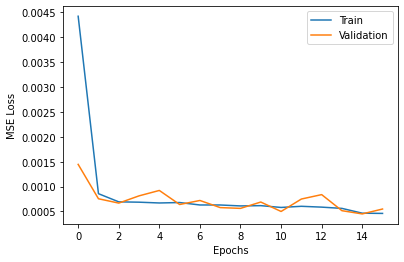

In [ ]:
plt.plot(logger.metrics['train_loss'], label='Train')
plt.plot(logger.metrics['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
print(np.sqrt(logger.metrics['val_loss'][-1]))

0.023441906604168995


### Testing

In [ ]:
# Get predicted results on test set

x_test, y_test = sliding_windows(df=test_df, window_size=int(best_choice[5]), target_column=target_column, flatten=False, output_window_size=1)
x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.FloatTensor(y_test)

test_pred = GRU_model(x_test_tensor).detach()

# Unscale the predictions and actual values
unscaled_test_pred = target_scaler.inverse_transform(test_pred.reshape(-1, 1))
unscaled_test_y = target_scaler.inverse_transform(y_test_tensor.reshape(-1,1))

unscaled_test_pred = torch.FloatTensor(unscaled_test_pred)
unscaled_test_y = torch.FloatTensor(unscaled_test_y)


------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------


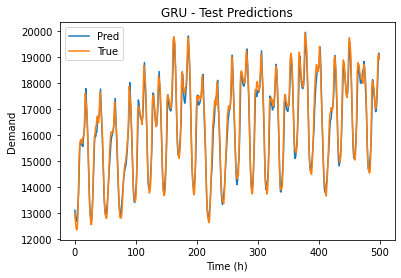

In [ ]:
# Plotting predicted demand
plt.plot(unscaled_test_pred[:500, 0], label='Pred')
plt.plot(unscaled_test_y[:500, 0], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Demand')
plt.title('GRU - Test Predictions')
plt.show()

In [ ]:
loss_fun = RMSELoss()
final_scaled_mse = loss_fun(test_pred, y_test_tensor)
final_unscaled_mse = loss_fun(unscaled_test_y, unscaled_test_pred)
test_mape = mean_absolute_percentage_error(unscaled_test_y, unscaled_test_pred)
print(final_scaled_mse)
print(final_unscaled_mse)
print(test_mape*100)

tensor(0.0259)
tensor(338.9409)
1.7041267827153206


#### Best network using standardization

In [ ]:
# Import the dataset
df = pd.read_csv('data/ON_demand_weather_17-20.csv', index_col=0)


# Do all the preprocessing required
from preprocessing.preprocessing import one_hot_encode_days, one_hot_encode_months, time_differencing, split_and_scale, sin_cos_waves, sliding_windows, split_and_scale_no_val


# Remove weather stations and market demand columns
df.drop(['Market Demand',
         'toronto_Temp (C)',
         'hamilton_Temp (C)',
         'ottawa_Temp (C)',
         'kitchener_Temp (C)',
         'london_Temp (C)',
         'windsor_Temp (C)'], axis=1, inplace=True)


# One-hot encode days of week, drop_column=True removes original ordinary column
# df = one_hot_encode_days(df, drop_column=True)


# One-hot encode months, drop_column=True removes original ordinary column
# df = one_hot_encode_months(df, drop_column=True)


# Create sin-cos-waves for datetime information
# possible sin_cos-columns for lst_of_freq=['HalfDay', 'Day', 'Week', 'TwoYears']
# if drop_datetime_columns=True, these columns will be dropped: Hour, Day of Month, Day of Week, Month
df = sin_cos_waves(df, lst_of_freq=['Day', 'Week'], drop_datetime_columns=True)


# Apply time-differencing
# 'lag' defines the time-differencing interval/step-size
# remove_first_rows=True removes those rows at the beginning of the differenced series that are NaNs
# df = time_differencing(df, column='Ontario Demand', lag=1, remove_first_rows=True)


# Apply scaling if desired and split dataset into train, validation, and testset
scaler = 'standard'  # Define the type of scaler, options are 'min-max', 'standard', and None
columns_to_scale = ['Ontario Demand', 'Weighted Average Temp (C)', 'Day sin', 'Day cos', 'Week sin', 'Week cos']  # Define columns to be scaled, add time-differenced column if applicable
target_column = columns_to_scale[0]  # Define target column (required to allow unscaling later), change to time-differenced column if applicable
vali_set_start_date='2019-07-01'  # First day of validation set
test_set_start_date='2020-01-01'  # First day of test set


train_std_df, vali_std_df, test_std_df, target_scaler_std = split_and_scale(df,
                                                            scaler=scaler,
                                                            columns_to_scale=columns_to_scale,
                                                            target_column=target_column,
                                                            vali_set_start_date=vali_set_start_date,
                                                            test_set_start_date=test_set_start_date)
'''
train_std_df,  test_std_df, target_scaler_std = split_and_scale_no_val(df,
                                                          scaler=scaler,
                                                          columns_to_scale=columns_to_scale,
                                                          target_column=target_column,
                                                          test_set_start_date=test_set_start_date)
#'''


train_std_df.drop(['Holiday'], axis = 1, inplace=True)
vali_std_df.drop(['Holiday'], axis = 1, inplace=True)
test_std_df.drop(['Holiday'], axis = 1, inplace=True) #Holiday feature skews results, observable even within the first 500h and 1000h of results




------------------------------
Encoded following frequencies via sin-cos waves:  ['Day', 'Week']
Dropped following columns: [Hour, Day of Month, Day of Week, Month]
------------------------------
------------------------------
Dataset scaled (if applicable) and split into:
Training data: 21864 rows
Validation data: 4416 rows
Test data: 8784 rows
------------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Import Results if we already have 
from numpy import genfromtxt
results = genfromtxt('/content/gdrive/MyDrive/ECSE_552/Project/GRU Search Results/GRU_Search_Results.csv', delimiter=',')
num_design_points = len(results)

In [ ]:
# Lightning Module

class GRU(pl.LightningModule):
  def __init__(self, num_features, target_size, hidden_layer_size, num_hidden_layers, dropout, start_lr, final_train = False):
    super().__init__()

    # Model hyperparameters
    self.hidden_layer_size = hidden_layer_size
    self.num_hidden_layers = num_hidden_layers
    self.dropout = dropout
    self.start_lr = start_lr

    self.final_train = final_train

    self.GRU = nn.GRU(num_features, self.hidden_layer_size, self.num_hidden_layers, dropout=self.dropout)
    self.linear = nn.Linear(self.hidden_layer_size, target_size)
    self.dropout_layer = nn.Dropout(p=self.dropout)
    
  def forward(self, x):
    GRU_out, _  = self.GRU(x)
    x = GRU_out[:, -1]
    x = self.dropout_layer(x)
    x = self.linear(x)
    return x

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.start_lr)
    if (not self.final_train):
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7)
      return_val = {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    else:
      scheduler = {
        "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7),
        "monitor": "train_loss"
        }
      return_val = {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "train_loss"}
    return return_val

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    return loss

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('val_loss', loss)

In [ ]:
# Get min val loss design index

best_index = np.argmin(results[:,7])
best_choice = results[best_index]
print(best_index)
print(best_choice[:6])

# Create Dataset

x_train_std, y_train_std = sliding_windows(df=train_std_df, window_size=int(best_choice[5]), target_column=target_column, flatten=False, output_window_size=1)
x_std_train_tensor = torch.FloatTensor(x_train_std)
y_std_train_tensor = torch.FloatTensor(y_train_std)

x_val_std, y_val_std = sliding_windows(df=vali_std_df, window_size=int(best_choice[5]), target_column=target_column, flatten=False, output_window_size=1)
x_std_val_tensor = torch.FloatTensor(x_val_std)
y_std_val_tensor = torch.FloatTensor(y_val_std)

train_std_data = TensorDataset(x_std_train_tensor, y_std_train_tensor)
val_std_data = TensorDataset(x_std_val_tensor, y_std_val_tensor)

# Create DataLoader
train_std_dataloader = DataLoader(train_std_data, batch_size=int(best_choice[0]), shuffle=True)
val_std_dataloader = DataLoader(val_std_data, batch_size=int(best_choice[0]), shuffle=False)

num_features = x_std_train_tensor.shape[2]
target_size = 1

GRU_std_model = GRU(num_features, target_size, int(best_choice[1]), int(best_choice[2]), best_choice[3], best_choice[4])

# Train model
std_lr_monitor = LearningRateMonitor(logging_interval='epoch')
std_logger = DictLogger()
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=0.0001, patience=5)
std_trainer = pl.Trainer(max_epochs=100, gpus=1, progress_bar_refresh_rate=30, logger=std_logger, callbacks=[early_stopping])
start_time = time.time()
    
std_trainer.fit(GRU_std_model, train_std_dataloader, val_std_dataloader)
std_training_time = time.time() - start_time
print(std_training_time)

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params
------------------------------------------
0 | GRU           | GRU     | 992 K 
1 | linear        | Linear  | 257   
2 | dropout_layer | Dropout | 0     
------------------------------------------
992 K     Trainable params
0         Non-trainable params
992 K     Total params
3.970     Total estimated model params size (MB)


0
[3.20e+01 2.56e+02 3.00e+00 0.00e+00 1.00e-03 2.40e+01]
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------



77.7954454421997


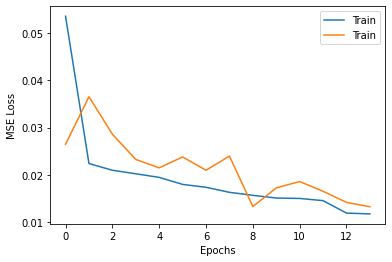

In [ ]:
plt.plot(std_logger.metrics['train_loss'], label='Train')
plt.plot(std_logger.metrics['val_loss'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
print(np.sqrt(std_logger.metrics['val_loss'][-1]))

0.11508223625344309


##### Testing

In [ ]:
# Get predicted results on test set

x_std_test, y_std_test = sliding_windows(df=test_std_df, window_size=int(best_choice[5]), target_column=target_column, flatten=False, output_window_size=1)
x_std_test_tensor = torch.FloatTensor(x_std_test)
y_std_test_tensor = torch.FloatTensor(y_std_test)

test_std_pred = GRU_std_model(x_std_test_tensor).detach()

# Unscale the predictions and actual values
unscaled_test_std_pred = target_scaler_std.inverse_transform(test_std_pred.reshape(-1, 1))
unscaled_test_std_y = target_scaler_std.inverse_transform(y_std_test_tensor.reshape(-1,1))

unscaled_test_std_pred = torch.FloatTensor(unscaled_test_std_pred)
unscaled_test_std_y = torch.FloatTensor(unscaled_test_std_y)

------------------------------
Sliding windows created using a window size of 24 and forecast length of 1.
------------------------------


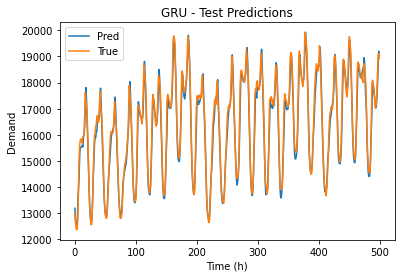

In [ ]:
plt.plot(unscaled_test_std_pred[:500, 0], label='Pred')
plt.plot(unscaled_test_std_y[:500, 0], label='True')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Demand')
plt.title('GRU - Test Predictions')
plt.show()

In [ ]:
loss_fun = RMSELoss()
final_scaled_std_mse =loss_fun(test_std_pred, y_std_test_tensor)
final_unscaled_std_mse = loss_fun(unscaled_test_std_y, unscaled_test_std_pred)
test_std_mape = mean_absolute_percentage_error(unscaled_test_std_y, unscaled_test_std_pred)
print(final_scaled_std_mse)
print(final_unscaled_std_mse)
print(test_std_mape*100)

tensor(0.1315)
tensor(294.8354)
1.4298844151198864


#### Best network multi-time step 24h

In [ ]:
# Import the dataset
df = pd.read_csv('data/ON_demand_weather_17-20.csv', index_col=0)


# Do all the preprocessing required
from preprocessing.preprocessing import one_hot_encode_days, one_hot_encode_months, time_differencing, split_and_scale, sin_cos_waves, sliding_windows, split_and_scale_no_val


# Remove weather stations and market demand columns
df.drop(['Market Demand',
         'toronto_Temp (C)',
         'hamilton_Temp (C)',
         'ottawa_Temp (C)',
         'kitchener_Temp (C)',
         'london_Temp (C)',
         'windsor_Temp (C)'], axis=1, inplace=True)


# One-hot encode days of week, drop_column=True removes original ordinary column
# df = one_hot_encode_days(df, drop_column=True)


# One-hot encode months, drop_column=True removes original ordinary column
# df = one_hot_encode_months(df, drop_column=True)


# Create sin-cos-waves for datetime information
# possible sin_cos-columns for lst_of_freq=['HalfDay', 'Day', 'Week', 'TwoYears']
# if drop_datetime_columns=True, these columns will be dropped: Hour, Day of Month, Day of Week, Month
df = sin_cos_waves(df, lst_of_freq=['Day', 'Week'], drop_datetime_columns=True)


# Apply time-differencing
# 'lag' defines the time-differencing interval/step-size
# remove_first_rows=True removes those rows at the beginning of the differenced series that are NaNs
# df = time_differencing(df, column='Ontario Demand', lag=1, remove_first_rows=True)


# Apply scaling if desired and split dataset into train, validation, and testset
scaler = 'min-max'  # Define the type of scaler, options are 'min-max', 'standard', and None
columns_to_scale = ['Ontario Demand', 'Weighted Average Temp (C)', 'Day sin', 'Day cos', 'Week sin', 'Week cos']  # Define columns to be scaled, add time-differenced column if applicable
target_column = columns_to_scale[0]  # Define target column (required to allow unscaling later), change to time-differenced column if applicable
vali_set_start_date='2019-07-01'  # First day of validation set
test_set_start_date='2020-01-01'  # First day of test set


train_24h_df, vali_24h_df, test_24h_df, target_scaler_24h = split_and_scale(df,
                                                            scaler=scaler,
                                                            columns_to_scale=columns_to_scale,
                                                            target_column=target_column,
                                                            vali_set_start_date=vali_set_start_date,
                                                            test_set_start_date=test_set_start_date)
'''
train_24h_df,  test_24h_df, target_scaler_24h = split_and_scale_no_val(df,
                                                          scaler=scaler,
                                                          columns_to_scale=columns_to_scale,
                                                          target_column=target_column,
                                                          test_set_start_date=test_set_start_date)
#'''


train_24h_df.drop(['Holiday'], axis = 1, inplace=True)
vali_24h_df.drop(['Holiday'], axis = 1, inplace=True)
test_24h_df.drop(['Holiday'], axis = 1, inplace=True) #Holiday feature skews results, observable even within the first 500h and 1000h of results




------------------------------
Encoded following frequencies via sin-cos waves:  ['Day', 'Week']
Dropped following columns: [Hour, Day of Month, Day of Week, Month]
------------------------------
------------------------------
Dataset scaled (if applicable) and split into:
Training data: 21864 rows
Validation data: 4416 rows
Test data: 8784 rows
------------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Import Results if we already have 
from numpy import genfromtxt
results = genfromtxt('/content/gdrive/MyDrive/ECSE_552/Project/GRU Search Results/GRU_Search_Results.csv', delimiter=',')
num_design_points = len(results)

In [ ]:
# Lightning Module

class GRU(pl.LightningModule):
  def __init__(self, num_features, target_size, hidden_layer_size, num_hidden_layers, dropout, start_lr, final_train = False):
    super().__init__()

    # Model hyperparameters
    self.hidden_layer_size = hidden_layer_size
    self.num_hidden_layers = num_hidden_layers
    self.dropout = dropout
    self.start_lr = start_lr

    self.final_train = final_train

    self.GRU = nn.GRU(num_features, self.hidden_layer_size, self.num_hidden_layers, dropout=self.dropout)
    self.linear = nn.Linear(self.hidden_layer_size, target_size)
    self.dropout_layer = nn.Dropout(p=self.dropout)
    
  def forward(self, x):
    GRU_out, _  = self.GRU(x)
    x = GRU_out[:, -1]
    x = self.dropout_layer(x)
    x = self.linear(x)
    return x

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.start_lr)
    if (not self.final_train):
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7)
      return_val = {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    else:
      scheduler = {
        "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, min_lr=1e-7),
        "monitor": "train_loss"
        }
      return_val = {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "train_loss"}
    return return_val

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    return loss

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x_hat = self(x)
    loss = F.mse_loss(x_hat, y)
    self.log('val_loss', loss)

In [ ]:
# Get min val loss design index

best_index = np.argmin(results[:,7])
best_choice = results[best_index]
print(best_index)
print(best_choice[:6])

# Create Dataset

x_train_24h, y_train_24h = sliding_windows(df=train_24h_df, window_size=int(best_choice[5]), target_column=target_column, flatten=False, output_window_size=24)
x_24h_train_tensor = torch.FloatTensor(x_train_24h)
y_24h_train_tensor = torch.FloatTensor(y_train_24h)

x_val_24h, y_val_24h = sliding_windows(df=vali_24h_df, window_size=int(best_choice[5]), target_column=target_column, flatten=False, output_window_size=24)
x_24h_val_tensor = torch.FloatTensor(x_val_24h)
y_24h_val_tensor = torch.FloatTensor(y_val_24h)

train_24h_data = TensorDataset(x_24h_train_tensor, y_24h_train_tensor)
val_24h_data = TensorDataset(x_24h_val_tensor, y_24h_val_tensor)

# Create DataLoader
train_24h_dataloader = DataLoader(train_24h_data, batch_size=int(best_choice[0]), shuffle=True)
val_24h_dataloader = DataLoader(val_24h_data, batch_size=int(best_choice[0]), shuffle=False)

num_features = x_24h_train_tensor.shape[2]
target_size = 24

GRU_24h_model = GRU(num_features, target_size, int(best_choice[1]), int(best_choice[2]), best_choice[3], best_choice[4])


# Train model
lr_monitor_24h = LearningRateMonitor(logging_interval='epoch')
logger_24h = DictLogger()
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=0.0001, patience=5)
trainer_24h = pl.Trainer(max_epochs=100, gpus=1, progress_bar_refresh_rate=30, logger=logger_24h, callbacks=[early_stopping])
start_time = time.time()
    
trainer_24h.fit(GRU_24h_model, train_24h_dataloader,val_24h_dataloader)
training_time_24h = time.time() - start_time
print(training_time_24h)

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params
------------------------------------------
0 | GRU           | GRU     | 992 K 
1 | linear        | Linear  | 6.2 K 
2 | dropout_layer | Dropout | 0     
------------------------------------------
998 K     Trainable params
0         Non-trainable params
998 K     Total params
3.994     Total estimated model params size (MB)


0
[3.20e+01 2.56e+02 3.00e+00 0.00e+00 1.00e-03 2.40e+01]
------------------------------
Sliding windows created using a window size of 24 and forecast length of 24.
------------------------------
------------------------------
Sliding windows created using a window size of 24 and forecast length of 24.
------------------------------



66.118079662323


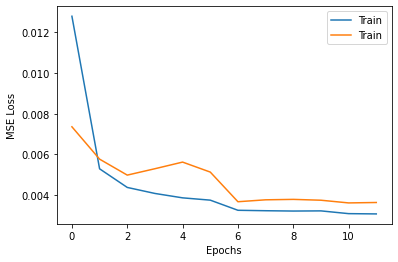

In [ ]:
plt.plot(logger_24h.metrics['train_loss'], label='Train')
plt.plot(logger_24h.metrics['val_loss'], label='Train')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
print(np.sqrt(logger_24h.metrics['val_loss'][-1]))

0.05556809786482664


##### Testing

In [ ]:
# Get predicted results on test set

x_24h_test, y_24h_test = sliding_windows(df=test_24h_df, window_size=int(best_choice[5]), target_column=target_column, flatten=False, output_window_size=24)
x_24h_test_tensor = torch.FloatTensor(x_24h_test)
y_24h_test_tensor = torch.FloatTensor(y_24h_test)

test_24h_pred = GRU_24h_model(x_24h_test_tensor).detach()

# Unscale the predictions and actual values
unscaled_test_24h_pred = target_scaler_24h.inverse_transform(test_24h_pred.reshape(-1, 1))
unscaled_test_24h_y = target_scaler_24h.inverse_transform(y_24h_test_tensor.reshape(-1,1))

unscaled_test_24h_pred = torch.FloatTensor(unscaled_test_24h_pred)
unscaled_test_24h_y = torch.FloatTensor(unscaled_test_24h_y)

------------------------------
Sliding windows created using a window size of 24 and forecast length of 24.
------------------------------


In [ ]:
loss_fun = RMSELoss()
final_scaled_24h_mse =loss_fun(test_24h_pred, y_24h_test_tensor)
final_unscaled_24h_mse = loss_fun(unscaled_test_24h_y, unscaled_test_24h_pred)
test_24h_mape = mean_absolute_percentage_error(unscaled_test_24h_y, unscaled_test_24h_pred)
print(final_scaled_24h_mse)
print(final_unscaled_24h_mse)
print(test_24h_mape*100)

tensor(0.0722)
tensor(944.3510)
4.7214556485414505


In [ ]:
predictions = []
for i in [0, 500, 1000, 3000]:
  pred = GRU_24h_model(x_24h_test_tensor[i].reshape(1, x_24h_test_tensor[i].shape[0], x_24h_test_tensor[i].shape[1])).detach()
  pred = pred.reshape(y_24h_test_tensor.shape[1])
  pred = pred.numpy()
  predictions.append(pred)



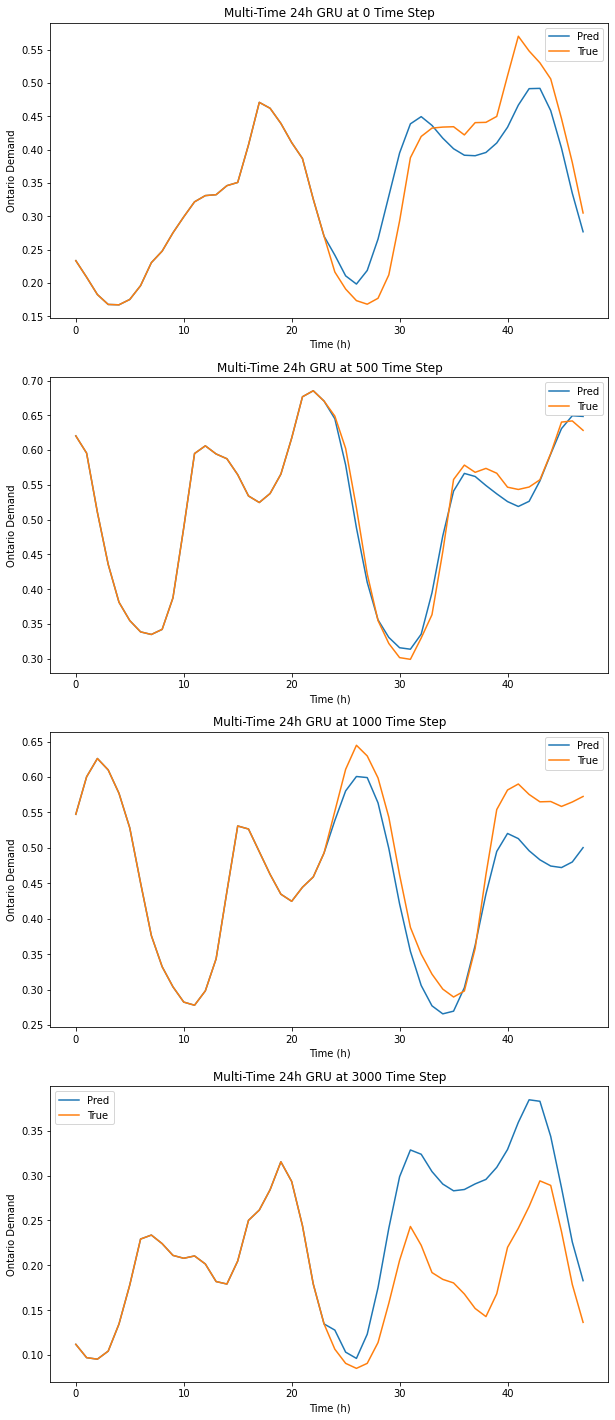

In [ ]:
j = 0
fig, ax = plt.subplots(4, 1,  figsize=(10, 25))
for i in [0, 500, 1000, 3000]:
  ax[j].plot(np.concatenate([x_24h_test_tensor[i][:int(best_choice[5]), -1], predictions[j]]), label='Pred')
  ax[j].plot(np.concatenate([x_24h_test_tensor[i][:int(best_choice[5]), -1], y_24h_test_tensor[i]]), label='True')
  ax[j].legend()
  ax[j].set_xlabel('Time (h)')
  ax[j].set_ylabel('Ontario Demand')
  ax[j].set_title('Multi-Time 24h GRU at {} Time Step'.format(i))
  j += 1
plt.show()

#### Best network autoregressive 24h

In [ ]:
# Import the dataset
df = pd.read_csv('data/ON_demand_weather_17-20.csv', index_col=0)


# Do all the preprocessing required
from preprocessing.preprocessing import one_hot_encode_days, one_hot_encode_months, time_differencing, split_and_scale, sin_cos_waves, sliding_windows, split_and_scale_no_val


# Remove weather stations and market demand columns
df.drop(['Market Demand',
         'toronto_Temp (C)',
         'hamilton_Temp (C)',
         'ottawa_Temp (C)',
         'kitchener_Temp (C)',
         'london_Temp (C)',
         'windsor_Temp (C)'], axis=1, inplace=True)


# One-hot encode days of week, drop_column=True removes original ordinary column
# df = one_hot_encode_days(df, drop_column=True)


# One-hot encode months, drop_column=True removes original ordinary column
# df = one_hot_encode_months(df, drop_column=True)


# Create sin-cos-waves for datetime information
# possible sin_cos-columns for lst_of_freq=['HalfDay', 'Day', 'Week', 'TwoYears']
# if drop_datetime_columns=True, these columns will be dropped: Hour, Day of Month, Day of Week, Month
df = sin_cos_waves(df, lst_of_freq=['Day', 'Week'], drop_datetime_columns=True)


# Apply time-differencing
# 'lag' defines the time-differencing interval/step-size
# remove_first_rows=True removes those rows at the beginning of the differenced series that are NaNs
# df = time_differencing(df, column='Ontario Demand', lag=1, remove_first_rows=True)


# Apply scaling if desired and split dataset into train, validation, and testset
scaler = 'min-max'  # Define the type of scaler, options are 'min-max', 'standard', and None
columns_to_scale = ['Ontario Demand', 'Weighted Average Temp (C)', 'Day sin', 'Day cos', 'Week sin', 'Week cos']  # Define columns to be scaled, add time-differenced column if applicable
target_column = columns_to_scale[0]  # Define target column (required to allow unscaling later), change to time-differenced column if applicable
vali_set_start_date='2019-07-01'  # First day of validation set
test_set_start_date='2020-01-01'  # First day of test set


train_AUTO_df, vali_AUTO_df, test_AUTO_df, target_scaler = split_and_scale(df,
                                                            scaler=scaler,
                                                            columns_to_scale=columns_to_scale,
                                                            target_column=target_column,
                                                            vali_set_start_date=vali_set_start_date,
                                                            test_set_start_date=test_set_start_date)
'''
train_AUTO_df,  test_AUTO_df, target_scaler_AUTO = split_and_scale_no_val(df,
                                                          scaler=scaler,
                                                          columns_to_scale=columns_to_scale,
                                                          target_column=target_column,
                                                          test_set_start_date=test_set_start_date)
#'''


train_AUTO_df.drop(['Holiday'], axis = 1, inplace=True)
vali_AUTO_df.drop(['Holiday'], axis = 1, inplace=True)
test_AUTO_df.drop(['Holiday'], axis = 1, inplace=True) #Holiday feature skews results, observable even within the first 500h and 1000h of results




------------------------------
Encoded following frequencies via sin-cos waves:  ['Day', 'Week']
Dropped following columns: [Hour, Day of Month, Day of Week, Month]
------------------------------
------------------------------
Dataset scaled (if applicable) and split into:
Training data: 21864 rows
Validation data: 4416 rows
Test data: 8784 rows
------------------------------


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Import Results if we already have 
from numpy import genfromtxt
results = genfromtxt('/content/gdrive/MyDrive/ECSE_552/Project/GRU Search Results/GRU_Search_Results.csv', delimiter=',')
num_design_points = len(results)

# Get min val loss design index

best_index = np.argmin(results[:,7])
best_choice = results[best_index]

In [ ]:
output_window_size=24

# Sliding windows
# note that the function removes the 'Date' column (not numeric)
x_AUTO_train, y_AUTO_train = sliding_windows(df=train_AUTO_df, window_size=int(best_choice[5]), target_column=target_column, flatten=False, output_window_size=output_window_size, autoregressive=True)
x_AUTO_vali, y_AUTO_vali = sliding_windows(df=vali_AUTO_df, window_size=int(best_choice[5]), target_column=target_column, flatten=False, output_window_size=output_window_size, autoregressive=True)
x_AUTO_test, y_AUTO_test = sliding_windows(df=test_AUTO_df, window_size=int(best_choice[5]), target_column=target_column, flatten=False, output_window_size=output_window_size, autoregressive=True)
# repeat function call for validation and test data

SHUFFLE_BUFFER_SIZE = 100
BATCH_SIZE = int(best_choice[0])
train_AUTO_dataset = tf.data.Dataset.from_tensor_slices((x_AUTO_train, y_AUTO_train)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_AUTO_dataset = tf.data.Dataset.from_tensor_slices((x_AUTO_vali, y_AUTO_vali)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)


class ARGRU(tf.keras.Model):
  def __init__(self, units, out_steps, rnn_layers, dropout):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.rnn_layers = rnn_layers
    self.dropout = dropout
    self.rnn_cells = []
    for _ in range(self.rnn_layers):
      self.rnn_cells.append(tf.keras.layers.GRUCell(self.units, dropout=self.dropout))

    self.stacked_gru = tf.keras.layers.StackedRNNCells(self.rnn_cells)
    self.GRU_layer = tf.keras.layers.RNN(self.stacked_gru, return_state=True)

    self.dense = tf.keras.layers.Dense(1)
          
  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, GRU_units)
    # print(inputs.shape)
    x, *state = self.GRU_layer(inputs)
    prediction = self.dense(x)
    return prediction, state

  def call(self, inputs, training=None):
    # print("start.....")
    # print(inputs.shape)
    warmup_input = inputs[:, :-self.out_steps, :]
    # print(warmup_input.shape)
    out_input = inputs[:, -self.out_steps:, :]
    # print(out_input.shape)
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the GRU state
    prediction, state = self.warmup(warmup_input)
    # print(pass_warmup)
            
    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(self.out_steps - 1):
      # Use the last electricity prediction as part of the input
      # print(out_input[:, n, :-1].shape)
      # print(prediction.shape)
      x = tf.concat([out_input[:, n, :-1], prediction], -1)
      # print(x.shape)
      # x = out_input[:, n, :]
      # Execute one GRU step.
      for layer in self.rnn_cells:
        x, state = layer(x, states=state,training=training) 
      # Convert the GRU output to a prediction.
      prediction = self.dense(x)
      # Add the prediction to the output
      predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/ECSE_552/Project/Checkpoints', save_weights_only=True)

ARGRU_model = ARGRU(int(best_choice[1]), output_window_size, int(best_choice[2]), best_choice[3])
ARGRU_model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.mse)
start_time = time.time()
history = ARGRU_model.fit(train_AUTO_dataset, epochs=500, validation_data=val_AUTO_dataset, callbacks=[early_stopping, lr_scheduler])
training_time_AR = time.time() - start_time
print(training_time_AR)


------------------------------
Autoregressive Sliding windows created using a window size of          24 and forecast length of 24.
------------------------------
------------------------------
Autoregressive Sliding windows created using a window size of          24 and forecast length of 24.
------------------------------
------------------------------
Autoregressive Sliding windows created using a window size of          24 and forecast length of 24.
------------------------------
Epoch 1/500
682/682 [==============================] - 124s 161ms/step - loss: 0.0183 - val_loss: 0.0195
Epoch 2/500
682/682 [==============================] - 108s 158ms/step - loss: 0.0083 - val_loss: 0.0167
Epoch 3/500
682/682 [==============================] - 107s 157ms/step - loss: 0.0080 - val_loss: 0.0142
Epoch 4/500
682/682 [==============================] - 106s 155ms/step - loss: 0.0074 - val_loss: 0.0140
Epoch 5/500
682/682 [==============================] - 107s 157ms/step - loss: 0.0069 - val

KeyboardInterrupt: ignored

##### Testing

In [ ]:
loss_fun = RMSELoss()
y_AUTO_pred = ARGRU_model.predict(x_AUTO_test)
y_AUTO_pred = y_AUTO_pred.reshape(y_AUTO_pred.shape[0], y_AUTO_pred.shape[1])
y_tensor_AUTO = torch.from_numpy(y_AUTO_test)
y_pred_tensor_AUTO = torch.from_numpy(y_AUTO_pred)
unscaled_y_pred_AUTO = torch.from_numpy(target_scaler_AUTO.inverse_transform(y_AUTO_pred.reshape(-1, 1)))
unscaled_target_AUTO = torch.from_numpy(target_scaler_AUTO.inverse_transform(y_AUTO_test.reshape(-1, 1)))

loss_unscaled = loss_fun(unscaled_y_pred_AUTO, unscaled_target_AUTO)
loss_scaled = loss_fun(y_pred_tensor_AUTO, y_tensor_AUTO)
test_AR_mape = mean_absolute_percentage_error(y_pred_tensor_AUTO, y_tensor_AUTO)

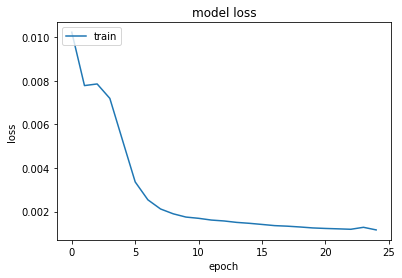

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
print(np.sqrt(history.history['val_loss'][-1]))
print(loss_scaled)
print(loss_unscaled)
print(test_AR_mape)

0.03397831691535392
tensor(0.0646, dtype=torch.float64)
tensor(843.9865, dtype=torch.float64)


In [ ]:
predictions = []
for i in [0, 500, 1000, 3000]:
  pred = ARGRU_model.predict(x_AUTO_test[i].reshape(1, x_AUTO_test[i].shape[0], x_AUTO_test[i].shape[1]))
  pred = pred.reshape(y_AUTO_pred.shape[1])
  predictions.append(pred)

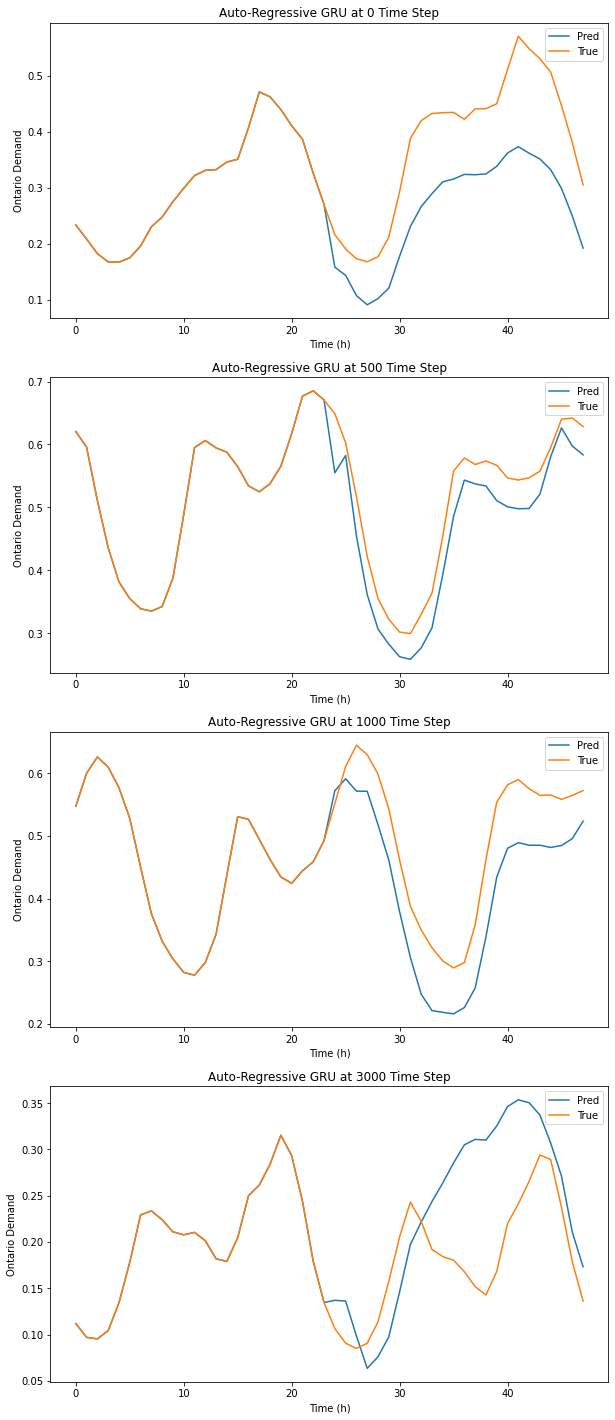

In [ ]:
j = 0
fig, ax = plt.subplots(4, 1,  figsize=(10, 25))
for i in [0, 500, 1000, 3000]:
  ax[j].plot(np.concatenate([x_AUTO_test[i][:int(best_choice[5]), -1], predictions[j]]), label='Pred')
  ax[j].plot(np.concatenate([x_AUTO_test[i][:int(best_choice[5]), -1], y_AUTO_test[i]]), label='True')
  ax[j].legend()
  ax[j].set_xlabel('Time (h)')
  ax[j].set_ylabel('Ontario Demand')
  ax[j].set_title('Auto-Regressive GRU at {} Time Step'.format(i))
  j += 1
plt.show()